    In diesem Jupyter Notebook untersuchen wir, welche Ursachen für einen Fehler in der Hochdruckkompressoreinheit (HPC) eines Flugantriebsmotors verantwortlich sind. Darüber hinaus verwenden wir verschiedene Sensoren, um die verbleibende Nutzungsdauer (remaining useful life RUL) vorherzusagen.

**RUL Prognostik**

Die Prognostik ist eine technische Disziplin, die sich darauf konzentriert, den Zeitpunkt vorherzusagen, zu dem ein System oder eine Komponente ihre beabsichtigte Funktion nicht mehr erfüllen wird. Dieser Leistungsmangel ist häufig ein Fehler, ab dem das System nicht mehr zur Erfüllung der gewünschten Leistung verwendet werden kann. Die vorhergesagte Zeit wird dann remaining useful life (RUL) sein, die ein wichtiges Konzept für die Entscheidungsfindung zur Schadensminderung darstellt.


![Propulsion Engine](https://www.sdsc-bw.de/image/engine.png)

                                   Fig.1 An der Motor sind verschiedene Sensoren installiert

## Experimentelles Szenario
Die in diesem Beispiel verwendeten Datensätze zusammen mit allen erforderlichen Informationen (Liste verwandter wissenschaftlicher Veröffentlichungen) sind im NASA Ames Prognostics-Datenarchiv verfügbar (http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/#turbofan)

Informationen zum Problem finden Sie unter http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/publications/#turbofan und Originaldaten sind bei http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/#turbofan

Die Daten wurden ursprünglich mit dem C-MAPPS-System (Commercial Modular Aero-Propulsion System Simulations) generiert. Wie in der folgenden Tabelle gezeigt, besteht der simulierte C-MAPSS-Datensatz aus 4 Unterdatensätzen mit unterschiedlichen Betriebs- und Fehlerbedingungen, was zu komplexen Beziehungen zu Sensoren führt. Verschiedene Unterdatensätze (FD001, FD002 usw.) enthalten unterschiedliche Anzahlen von Trainings- und Testtrajektorien.


| Data Set | Train trjectories | Test trajectories | Conditions      | Fault Mode                             |
|----------|:-----------------:|------------------:|-----------------|----------------------------------------|
| FD001    |        100        |               100 | ONE (Sea Level) | ONE (HPC Degradation)                  |
| FD002    |        260        |               259 | SIX             | ONE (HPC Degradation)                  |
| FD003    |        100        |               100 | ONE (Sea Level) | TWO (HPC Degradation, Fan Degradation) |
| FD004    |        248        |               249 | SIX             | TWO (HPC Degradation, Fan Degradation) |

Datensätze bestehen aus multiple Zeitreihengruppen. Jede Zeitreihengruppe stammt von verschiedenem Motor. Die Daten stammen aus einer Reihen von Motoren desselben Typs. Alle Motoren laufen beim Start im normalen Zustand und beginnen sich irgendwann während der Zeitreihe zu verschlechtern (Degradation). Die Degradation in den Trainingssätzen nimmt bis zum Ausfall zu, während die Degradation in den Testsätzen irgendwann vor dem Ausfall endet, das ist die RUL. Das Ziel besteht darin, mithilfe verfugbarer Sensorinformationen die Anzahl der verbleibenden Betriebszyklen vor dem Ausfall vorherzusagen.

Jede Zeitreihengruppe enthält 26 Spalten: Motornummer, Zeitschritt, Drei betriebsbereite Sensoreinstellungen und 21 Sensormessungen.

| Column| Train trjectories | 
|----------|:-----------------|
| 1    |        unit number        |   
| 2    |        time, in cycles        |     
| 3    |        operational setting 1        |   
| 4    |        operational setting 2        |             
| 5    |        operational setting 3        |           
| 6    |        sensor measurement  1        |              
| 7    |        sensor measurement  2        |     
| ...  |        ...       |  
| 26   |        sensor measurement  3        |    

References: 

1. A. Saxena, K. Goebel, D. Simon, and N. Eklund, "Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation", in the Proceedings of the Ist International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008., retrieved feb. 2016
2. NASA Ames Prognostics data repository, retrieved feb. 2016, http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/
3. [Major Challenges in Prognostics: Study on Benchmarking Prognostics Datasets](https://www.phmsociety.org/sites/phmsociety.org/files/phm_submission/2012/phmce_12_004.pdf), O. F. Eker1, F. Camci, and I. K. Jennions1, retrieved feb. 2016


# importieren wichtige Pakete

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from numpy.polynomial.polynomial import Polynomial
pd.set_option('display.max_columns', 500)
# für Visualisierung

#plt.rcParams.keys()
plt.rcParams['ytick.labelsize'] = "large"
plt.rcParams['xtick.labelsize'] = "large"
plt.rcParams['axes.labelsize'] = "large"
plt.rcParams['figure.titlesize'] = "x-large"


import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt

# Daten lesen und visualisieren

## load the data

In [1]:
# Eingabedateien haben keine Spaltennamen, hier die Namen der Spalte wird definiert
# Es enthält 26 Spalten: Motornummer, Zeitschritt, Drei betriebsbereite Sensoreinstellungen und 21 Sensormessungen.

# Motornummer, Zeitschritt
index_columns_names =  ["UnitNumber","Cycle"]
# 3 betriebsbereite Sensoreinstellungen
operational_settings_columns_names = ["Operation Setting "+str(i) for i in range(1,4)]
# 21 Sensormessungen
sensor_measure_columns_names =["Sensor Measure"+str(i) for i in range(1,22)]

input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

In [4]:
# Laden die Daten FD001 als Beispiel
print("Laden der Daten beginnt!")
train_data = pd.read_csv('./data/train_FD001.txt', delim_whitespace=True, header=None)
train_data.columns = input_file_column_names
print("Laden der Daten ist fertig!")
print("Größe der Daten : Rows {}, Columns {}".format(train_data.shape[0], train_data.shape[1]))
train_data.head()

Laden der Daten beginnt!
Laden der Daten ist fertig!
Größe der Daten : Rows 20631, Columns 26


,UnitNumber,Cycle,Operation Setting 1,Operation Setting 2,Operation Setting 3,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [5]:
train_data['rul'] = train_data.groupby('UnitNumber')['Cycle'].transform(lambda x: x.max() - x)
train_data['rul'] = train_data['rul'].apply(lambda x: min(x, 130))
train_data.drop(['Operation Setting 1','Operation Setting 2','Operation Setting 3', 'Cycle'], axis=1, inplace=True)
train_data

,UnitNumber,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21,rul
0,1,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,130
1,1,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,130
2,1,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,130
3,1,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,130
4,1,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


## Schritt 1: Daten Normalisierung und Glättung 

In [6]:
X = train_data.drop(['rul'], axis=1)
y = train_data['rul'].values


### Entferne Spalten mit konstantem Werten

In [7]:
def identify_and_remove_unique_columns(Dataframe):
    unique_counts = Dataframe.nunique()
    # identify columns with only one unique value and drop them (constant values)
    record_single_unique = pd.DataFrame(unique_counts[unique_counts == 1]).reset_index().rename(columns = {'index': 'feature', 0: 'nunique'})
    to_drop = list(record_single_unique['feature'])
    Dataframe = Dataframe.drop(columns = to_drop)
    return Dataframe

print("Größe vor der Verarbeitung ", train_data.shape)
X = identify_and_remove_unique_columns(X)
print("Größe Nach der Verarbeitung", X.shape)
sensor_columns = [col for col in X.columns if 'Sensor Measure' in col]

Größe vor der Verarbeitung  (20631, 23)
Größe Nach der Verarbeitung (20631, 16)


### Daten Normalisieren mit Z-Score

In [8]:
scaler = StandardScaler()

# Normalisierung der Sensormessungen
normalized_data = X.copy()
normalized_data[sensor_columns] =  scaler.fit_transform(X[sensor_columns])
normalized_data

,UnitNumber,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure17,Sensor Measure20,Sensor Measure21
0,1,-1.721725,-0.134255,-0.925936,0.141683,1.121141,-0.516338,-0.862813,-0.266467,0.334262,-1.058890,-0.269071,-0.603816,-0.781710,1.348493,1.194427
1,1,-1.061780,0.211528,-0.643726,0.141683,0.431930,-0.798093,-0.958818,-0.191583,1.174899,-0.363646,-0.642845,-0.275852,-0.781710,1.016528,1.236922
2,1,-0.661813,-0.413166,-0.525953,0.141683,1.008155,-0.234584,-0.557139,-1.015303,1.364721,-0.919841,-0.551629,-0.649144,-2.073094,0.739891,0.503423
3,1,-0.661813,-1.261314,-0.784831,0.141683,1.222827,0.188048,-0.713826,-1.539489,1.961302,-0.224597,-0.520176,-1.971665,-0.781710,0.352598,0.777792
4,1,-0.621816,-1.251528,-0.301518,0.141683,0.714393,-0.516338,-0.457059,-0.977861,1.052871,-0.780793,-0.521748,-0.339845,-0.136018,0.463253,1.059552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,1.618000,1.216258,2.188375,0.141683,-2.189329,1.315066,0.012547,1.980044,-2.607969,2.278282,-0.322542,1.425294,2.446751,-1.805173,-2.921113
20627,100,1.717992,2.279706,2.738351,0.141683,-2.833345,1.878576,-0.006020,1.867718,-2.350355,1.722087,-0.380207,1.913240,1.155367,-2.856395,-1.203764
20628,100,1.478011,1.946971,2.138377,0.141683,-2.742957,2.019453,0.029755,2.054927,-1.902919,2.000184,-0.141684,3.265092,3.092444,-2.081810,-3.292481
20629,100,1.098043,2.403666,1.955051,0.141683,-3.036719,2.160330,0.383884,3.178182,-2.363913,1.861136,-0.233948,2.579834,1.155367,-2.911722,-2.085072


### Polynomial fitting

In [9]:
# Polynomial fitting
def poly_fit(df, degree):
    fitted_data = np.zeros(df.shape)
    for i, column in enumerate(df.columns):
        poly = Polynomial.fit(range(len(df)), df[column], degree)
        fitted_data[:, i] = poly(range(len(df)))
    return pd.DataFrame(fitted_data, columns=df.columns)

In [21]:
def fit_polynomial_for_all_units (df, col_name_unit_number):
    X_final = df.copy()[df[col_name_unit_number] == 1]
    X_final[sensor_columns] = poly_fit(X_final[sensor_columns], degree=3)
    X_final

    for id in range(2,len(df[col_name_unit_number].unique())+1):
        #apply the polynomial fitting to each unit
        unit_data = df[df[col_name_unit_number] == id]
        unit_data = poly_fit(unit_data[sensor_columns], degree=3)
        unit_data[col_name_unit_number] = id
        X_final=pd.concat([X_final, unit_data], axis=0)
    return X_final

In [22]:
X_final = fit_polynomial_for_all_units(normalized_data, 'UnitNumber')
X_final

,UnitNumber,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure17,Sensor Measure20,Sensor Measure21
0,1,-0.798512,-0.466045,-0.983026,0.141683,0.930287,-0.569979,-0.687156,-1.111285,0.870001,-0.773328,-0.552246,-0.970137,-0.896622,1.015534,1.062681
1,1,-0.794304,-0.472907,-0.980079,0.141683,0.925949,-0.566511,-0.686939,-1.100674,0.870436,-0.766315,-0.555730,-0.956198,-0.892935,1.001607,1.051339
2,1,-0.790239,-0.479704,-0.977208,0.141683,0.921728,-0.563196,-0.686718,-1.090309,0.870859,-0.759472,-0.559093,-0.942654,-0.889361,0.988028,1.040274
3,1,-0.786313,-0.486435,-0.974409,0.141683,0.917621,-0.560029,-0.686495,-1.080185,0.871266,-0.752793,-0.562339,-0.929500,-0.885896,0.974791,1.029482
4,1,-0.782522,-0.493098,-0.971679,0.141683,0.913625,-0.557005,-0.686270,-1.070297,0.871655,-0.746275,-0.565470,-0.916729,-0.882537,0.961891,1.018957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,100,1.623472,1.702633,2.173965,0.191787,-2.372238,2.001077,0.068997,2.214583,-2.177596,2.004340,-0.201257,2.109335,1.824536,-2.266227,-1.960478
196,100,1.650759,1.732527,2.223758,0.196069,-2.425160,2.045845,0.068755,2.256343,-2.224562,2.042738,-0.208027,2.156722,1.861622,-2.314811,-1.998112
197,100,1.678255,1.762674,2.274249,0.200485,-2.478814,2.091193,0.068474,2.298530,-2.272126,2.081496,-0.214939,2.204733,1.899203,-2.364010,-2.036144
198,100,1.705960,1.793075,2.325441,0.205036,-2.533206,2.137124,0.068154,2.341149,-2.320291,2.120615,-0.221995,2.253371,1.937283,-2.413829,-2.074577


## Schritt 2: Feature-Auswahl mit Lasso-Regression

In [14]:
def lasso_feature_selection(X, y, alpha=2.5):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    return lasso.coef_ != 0

In [15]:
selected_features_mask = lasso_feature_selection(X_final[sensor_columns].values, y)
selected_features = np.array(sensor_columns)[selected_features_mask]
selected_features

array(['Sensor Measure4', 'Sensor Measure9', 'Sensor Measure11'],
      dtype='<U16')

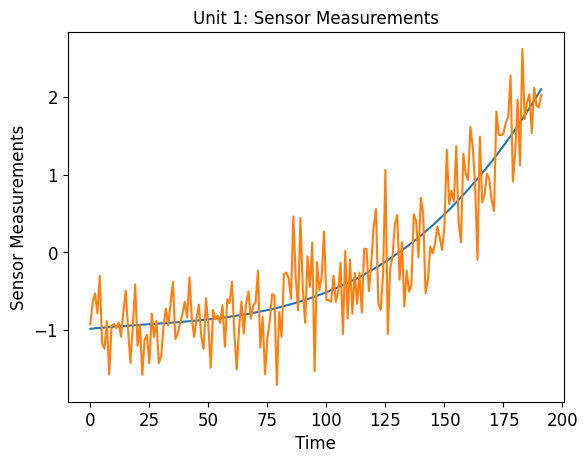

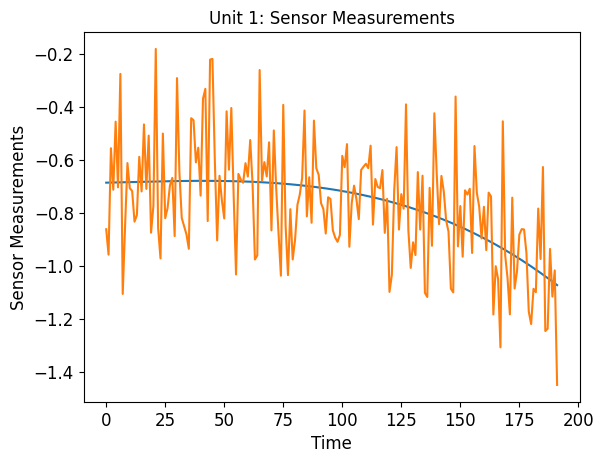

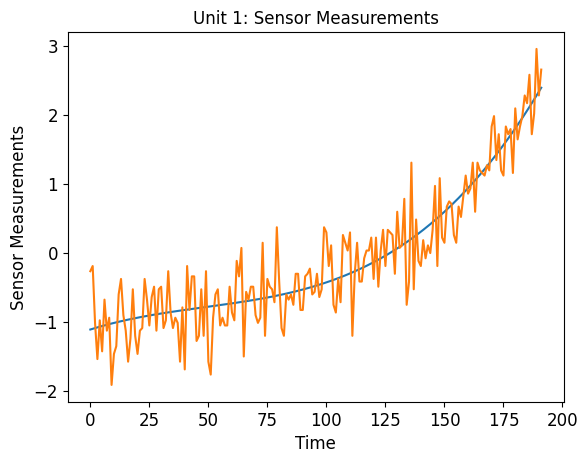

In [24]:
# visualize the unsmoothed and smmothed data for unit 1 for each sensor separately
for col in selected_features:
    plt.plot(X_final[X_final['UnitNumber'] == 1][col], label=col)
    plt.plot(normalized_data[normalized_data['UnitNumber'] == 1][col], label=col+'_original')
        
    plt.title('Unit 1: Sensor Measurements')
    plt.xlabel('Time')
    plt.ylabel('Sensor Measurements')
    plt.show()

### Schritt 3: Feature-Extraktion 

In [25]:
cols = list(selected_features)
cols.append("UnitNumber")
relevant_features = pd.concat([X_final[cols].reset_index(drop=True), pd.DataFrame(y,columns =['rul'])], axis=1)
relevant_features


,Sensor Measure4,Sensor Measure9,Sensor Measure11,UnitNumber,rul
0,-0.983026,-0.687156,-1.111285,1,130
1,-0.980079,-0.686939,-1.100674,1,130
2,-0.977208,-0.686718,-1.090309,1,130
3,-0.974409,-0.686495,-1.080185,1,130
4,-0.971679,-0.686270,-1.070297,1,130
...,...,...,...,...,...
20626,2.173965,0.068997,2.214583,100,4
20627,2.223758,0.068755,2.256343,100,3
20628,2.274249,0.068474,2.298530,100,2
20629,2.325441,0.068154,2.341149,100,1


In [36]:
window_length = 20
stride = 20

def extract_features(df, window_length, stride):
    features = []
    targets = []
    for unit in df['UnitNumber'].unique():
        unit_df = df[df['UnitNumber'] == unit]
        for start in range(0, len(unit_df) - window_length , stride):
            end = start + window_length 
            window = unit_df.iloc[start:end]
            feature_vector = []
            for sensor in selected_features:
                mean_val = window[sensor].mean()
                trend = np.polyfit(range(window_length), window[sensor], 1)[0]
                feature_vector.extend([mean_val, trend])
            features.append(feature_vector)
            targets.append(unit_df.iloc[end]['rul'])
    cols = []
    for sensor in selected_features:
        cols.extend([sensor + '_mean', sensor + '_trend'])
    return np.array(features), cols, np.array(targets)


test , cols, y_test = extract_features(relevant_features, window_length, stride)
pd.DataFrame(test, columns=cols)    

,Sensor Measure4_mean,Sensor Measure4_trend,Sensor Measure9_mean,Sensor Measure9_trend,Sensor Measure11_mean,Sensor Measure11_trend
0,-0.958532,0.002420,-0.685021,0.000225,-1.023262,0.008633
1,-0.914516,0.002163,-0.681247,0.000130,-0.883414,0.005629
2,-0.861981,0.003272,-0.681077,-0.000135,-0.782820,0.004707
3,-0.773626,0.005746,-0.687891,-0.000569,-0.679862,0.005866
4,-0.622146,0.009584,-0.705070,-0.001172,-0.532923,0.009105
...,...,...,...,...,...,...
967,-0.227495,0.005975,-0.060563,0.002081,-0.238103,0.009223
968,-0.073475,0.009708,-0.020408,0.001917,-0.012851,0.013423
969,0.176343,0.015555,0.015182,0.001625,0.305443,0.018527
970,0.564233,0.023516,0.043655,0.001205,0.734855,0.024535


## Train Random Forest regressor with C-Fold Cross validation

In [39]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer

In [308]:
def custom_score(true_rul, predicted_rul):
    scores = []
    for true, pred in zip(true_rul, predicted_rul):
        if pred < true:
            score = np.exp((true - pred) / 13) - 1
        else:
            score = np.exp((pred - true) / 10) - 1
        scores.append(score)
    mean_score = np.mean(scores)
    return mean_score

# Create the custom scorer
custom_scorer = make_scorer(custom_score, greater_is_better=False)

In [43]:
rf_regressor = RandomForestRegressor()
param_grid = {
    'n_estimators': range(10, 101, 10),  # Number of trees in the forest
    'max_samples': np.arange(0.3,1,0.1)  # Minimum number of samples required to be at a leaf node
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(rf_regressor, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(test, y_test)

best_rf_model = grid_search.best_estimator_

In [314]:
best_rf_model

RandomForestRegressor(max_samples=0.7000000000000002)

In [44]:
best_rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': 0.7000000000000002,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 60,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Prediction

In [316]:
# Beispielvorhersage für Testdaten
test_data = pd.read_csv('./data/test_FD001.txt', delim_whitespace=True, header=None)
test_data.columns = input_file_column_names



In [317]:
scaler.transform(test_data)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Cycle
- Operation Setting 1
- Operation Setting 2
- Operation Setting 3
- UnitNumber
